In [1]:
import quantrautil as q
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
print("Try inputting com")
stock = input("Enter a stock: ")
data = q.get_data(stock,'2005-2-1','2019-1-1')
print(data.tail())

/usr/local/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



Try inputting com
Enter a stock: AAPL
[*********************100%***********************]  1 of 1 downloaded
              Open    High     Low   Close  Adj Close    Volume Source
Date                                                                  
2018-12-24  148.15  151.55  146.59  146.83     144.66  37169200  Yahoo
2018-12-26  148.30  157.23  146.72  157.17     154.84  58582500  Yahoo
2018-12-27  155.84  156.77  150.07  156.15     153.84  53117100  Yahoo
2018-12-28  157.50  158.52  154.55  156.23     153.92  42291400  Yahoo
2018-12-31  158.53  159.36  156.48  157.74     155.41  35003500  Yahoo


 In this step, I will create the input and output variable.
Input variable: I have used '(Open - Close)/Open', '(High - Low)/Low', standard deviation of last 5 days returns (std_5), and average of last 5 days returns (ret_5)
Output variable: If tomorrow’s close price is greater than today's close price then the output variable is set to 1 and otherwise set to -1. 1 indicates to buy the stock and -1 indicates to sell the stock.

In [2]:
# Features construction 
data['Open-Close'] = (data.Open - data.Close)/data.Open
data['High-Low'] = (data.High - data.Low)/data.Low
data['percent_change'] = data['Adj Close'].pct_change()
data['std_5'] = data['percent_change'].rolling(5).std()
data['ret_5'] = data['percent_change'].rolling(5).mean()
data.dropna(inplace=True)

# X is the input variable
X = data[['Open-Close', 'High-Low','std_5','ret_5','Open','Close']]

# Y is the target or output variable
# Here if the next day adj close is higher than the previous day then its 1 otherwise a 0
y = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)


In [3]:
# Total dataset length
dataset_length = data.shape[0]

# Training dataset length
split = int(dataset_length * 0.9)
split

3148

In [4]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3148, 6) (350, 6)
(3148,) (350,)


In [5]:
clf = RandomForestClassifier(n_estimators=20,random_state=None)
model = clf.fit(X_train, y_train)

import numpy as np

# Use the forest's predict method on the test data
predictions = clf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
round(np.mean(errors), 2)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0

53.42857142857142

In [6]:
sorted(zip(X.columns, clf.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('ret_5', 0.1765979991173427),
 ('Open-Close', 0.17577328068373618),
 ('High-Low', 0.17485754827686767),
 ('std_5', 0.1669158989060926),
 ('Open', 0.1563402582438707),
 ('Close', 0.14951501477209023)]

In [7]:
data['strategy_returns_on_adj_close'] = data.ret_5.shift(-1) * model.predict(X)

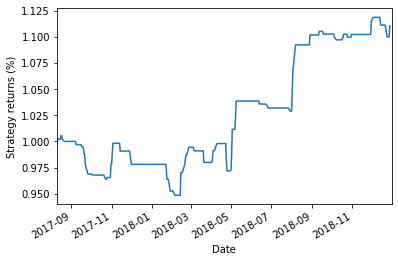

In [8]:
(data.strategy_returns_on_adj_close[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()